## Способ "в лоб"

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate
from scipy import misc
import pandas as pd
from scipy.ndimage.interpolation import geometric_transform
import os
from timeit import default_timer as timer
import tqdm

def FBT1(pol, m, x, u_net, theta_net):
    f1 = np.exp(-1j*m*theta_net)
    f2 = pol * f1
    fm = np.trapz(f2, theta_net, axis=1)
    fm = fm / (2 * np.pi)
#     Fm = np.zeros(x_net.shape, dtype=fm.dtype)
#     flag = m < 0
    ff = sp.special.jv(m, u_net*x) * fm * u_net
#     if m < 0:
#         ff *= (-1)**(-1*m)
    Fm = np.trapz(np.real(ff), u_net, axis=0) + 1j*np.trapz(np.imag(ff), u_net, axis=0)
    return Fm

def polar_trfm(Im, ntheta, nrad, rmax):
    #Polar Transform
    rows, cols = Im.shape
    cx = (rows+1)/2
    cy = (cols+1)/2
#     rmax=(rows-1)/2
#     deltatheta = 2 * np.pi/(ntheta)
#     deltarad = rmax/(nrad-1)
    theta_int = np.linspace(0, 2*np.pi, ntheta)
    r_int = np.linspace(0, rmax, nrad)
    theta, radius = np.meshgrid(theta_int, r_int)
    def transform(coords):
        theta = 2.0*np.pi*coords[1] / ntheta
        radius = rmax * coords[0] / nrad
        i = cx + radius*np.cos(theta)
        j = radius*np.sin(theta) + cy
        return i,j

    PolIm = geometric_transform(Im.astype(float), transform, order=1, mode='constant', output_shape=(nrad, ntheta))
    PolIm[np.isnan(PolIm[:])] = 0
    return PolIm

In [2]:
A = 64
p_s = 1
# im = np.arange(-60, 60, p_s)
# ih = np.arange(-60, 60, p_s)
# imm = np.arange(0, 120, p_s)
ro_max = 7
# ro_max = 0.025 * 2*A #maximum expected offset of COM
k = ro_max/p_s
b = ro_max/2
eps = np.pi/(2*k)
# B = 128
# s_ang = 2*B
s_ang = np.pi*A/p_s
B = s_ang/2
s_rad = 2*B/np.pi
theta_net = np.linspace(0, 2*np.pi, int(s_ang))
u_net = np.linspace(0, A, int(s_rad))
# x_net = np.linspace(0, B/A-1, s_rad)
ksi_net = np.linspace(0, 2*np.pi, int(np.pi*k))
eta_net = np.linspace(0, 2*np.pi, int(k))

m0 = lambda x: A*np.e*0.5*x - A*A*x*x/B*(0.5*np.e - 1)
M = np.zeros(int(s_rad), dtype=float)
H = np.zeros(int(s_rad), dtype=float)
# MM = np.array(m0(x_net))
for i in range(int(s_rad)):
    xj = i*np.pi*0.5/A
#     print(xj == x_net[i])
    M[i] = min(np.e*b*xj*0.5, 2*B*b/A - 1)
    H[i] = min(np.e*b*xj*0.5, 2*B*b/(np.pi*A) - 1)

In [3]:
path_in = "/Users/anoshin_alexey/Documents/Projects/Fast-Bessel-Matching/"

im1 = misc.imread(path_in + "imm.png")
pol1 = polar_trfm(im1, int(s_ang), int(s_rad), A)

im2 = misc.imread(path_in + "test/1/imm3.png")
pol2 = polar_trfm(im2, int(s_ang), int(s_rad), A)

Tf = np.zeros((int(np.pi*k), int(k), int(B)), dtype='complex')
print(Tf.shape)
          
for j in tqdm.tqdm(np.arange(0, 2*B/np.pi - 1, dtype=int)):
    for m1 in np.arange(-M[j], M[j], dtype=int):
        c1 = sp.special.jv(m1, b * xj) * xj
        xj = j*np.pi*0.5/A
        for h1 in np.arange(-H[j], H[j], dtype=int):
            c2 = sp.special.jv(h1, b * xj) * c1
            for mm in np.arange(0, m0(xj), dtype=int):
#                 print(mm)
                Fm = FBT1(pol1, int(m1+h1+mm), xj, u_net, theta_net)
                Gm = FBT1(pol2, int(mm), xj, u_net, theta_net)
#                 print(Fm, Gm)
                im1 = (m1 + M[j]).astype(int)
                ih1 = (h1 + H[j]).astype(int)
#                 print(im1, ih1, mm)
                Tf[im1, ih1, mm] += Fm * np.conj(Gm) * c2
print("done")
print(Tf.shape)           

 11%|█         | 7/63 [00:00<00:01, 50.45it/s]

(21, 7, 100)


100%|██████████| 63/63 [03:55<00:00,  3.74s/it]

done
(21, 7, 100)


In [62]:
print(Tf.shape)
m = -1
h = -1
for m1 in tqdm.tqdm(np.arange(-np.pi*k*0.5 + 1, np.pi*k*0.5 - 1, dtype=int)):
    m += 1
    h = -1
    for h1 in np.arange(-k*0.5 + 1, k*0.5 - 1, dtype=int):
        h += 1
        for mm in np.arange(0, B-1, dtype=int):
            im1 = m
            ih1 = h

            Tf[im1, ih1, mm] *= 2*np.pi*np.exp(1j*(h1+mm)*eps)

100%|██████████| 30/30 [00:00<00:00, 208.76it/s]

(31, 10, 100)


In [63]:
T = np.fft.ifftn(Tf)
print(T.dtype)
omega_net = np.linspace(0, 2*np.pi, Tf.shape[2])
# print(T.shape)
[ipsi, ietta, iomegga] = np.unravel_index(np.argmax(np.real(T), axis=None), T.shape)
ksi = ksi_net[ipsi]
etta = eta_net[ietta]
omegga = omega_net[iomegga]
print(np.degrees(ksi), np.degrees(etta), np.degrees(omegga))
print(np.degrees(ksi), np.degrees(etta - ksi), np.degrees(omegga - etta))
alpha = eps + omegga
phi = np.angle( np.exp(1j*(etta - ksi + eps)))
rho = np.abs(b * np.sqrt(2*(1 + np.cos(etta - ksi + eps))))
# rho = np.abs(np.complex(b+b*np.exp(etta - ksi + eps)))
rhoo = np.abs(b * np.sqrt(2*(1 + np.cos(np.radians(10 + 11.25)))))
phi = np.angle(np.exp(1j*ksi)*b*(1 + np.exp(1j*(etta - ksi + eps))))
x = rho * np.cos(phi)
y = rho * np.sin(phi)
a = alpha * 180 / np.pi % 360
print(a)


complex128
312.0 80.0 290.909090909
312.0 -232.0 210.909090909
299.909090909


## Изначальный способ (оптимизированный)

In [67]:
import numpy as np
import scipy as sp
from scipy import misc
from scipy.integrate import simps
import pandas as pd
from scipy.ndimage.interpolation import geometric_transform
import os
from timeit import default_timer as timer
import tqdm

def FBT(pol, m, x_net, u_net, theta_net):
    #compute formulas 10 and 11 from article
    #Parameters: 
    #pol : image resampled to polar coordinates
    #m : order of Bessel function (non integer give errors)
    #x_net : vector of x from formula 10
    # u_net, theta_net: polar grid of the given image
    #return: vector of len(x_net)
    
    f1 = np.exp(-1j*m*theta_net)
    f2 = pol * f1.reshape(1,-1)
#     f2 = np.fft.fft(pol*np.exp(-1j*m), axis=1)
    fm = np.trapz(np.real(f2), theta_net, axis=1) + 1j * np.trapz(np.imag(f2), theta_net, axis=1)
    fm = fm / (2 * np.pi)
#     Fm = np.zeros(x_net.shape, dtype=fm.dtype)

    bessel = sp.special.jv(m, u_net.reshape(-1, 1).
                       dot(x_net.reshape(1, -1)))
#     if m < 0:
#         bessel *= (-1)**abs(m)
    ff = bessel * fm.reshape(-1,1) * u_net.reshape(-1,1)
#     ff = sp.special.jn(m, u_net.dot(x_net)) * fm * u_net

    Fm = np.trapz(np.real(ff), u_net, axis=0) + 1j * np.trapz(np.imag(ff), u_net, axis=0)
    return Fm

def polar_trfm(Im, ntheta, nrad, rmax):
    #Polar Transform of the image with given numbers
    # of polar grid samples and maximal radius
    rows, cols = Im.shape
    cx = (rows+1)/2
    cy = (cols+1)/2
#     rmax=(rows-1)/2
#     deltatheta = 2 * np.pi/(ntheta)
#     deltarad = rmax/(nrad-1)
    theta_int = np.linspace(0, 2*np.pi, ntheta)
    r_int = np.linspace(0, rmax, nrad)
    theta, radius = np.meshgrid(theta_int, r_int)
    def transform(coords):
        theta1 = 2.0*np.pi*coords[1] / ntheta
        radius1 = rmax * coords[0] / nrad
        i = cx + radius1*np.cos(theta1)
        j = radius1*np.sin(theta1) + cy
        return i, j
#     xi = radius * np.cos(theta) + cx
#     yi = radius * np.sin(theta) + cy
    PolIm = geometric_transform(Im.astype(float), transform, order=1, mode='constant', output_shape=(nrad, ntheta))
    PolIm[np.isnan(PolIm[:])] = 0
    return PolIm

#Init the bandwith B, displacement samples k
# A = 64 #radius of the image
# p_s = 0.5
# s_ang = np.pi*A/p_s
B = 128

#section 2.2.1: number of angular samples 
#to be used in formula 10, 11
s_ang = 2*B
p_s = np.pi*A/ s_ang
# B = s_ang/2
print('B=', B)

#section 2.2.1: number of radial samples 
#to be used in formula 10, 11
s_rad = 2*B/np.pi

#maximum expected offset of COM
ro_max = 10
# ro_max = 0.025 * 2*A #maximum expected offset of COM
# k = ro_max/p_s
# print('k=', k)

#displacement samples k
k = 10
b = ro_max / 2
# p_s = 2 * b / k

#radius of the image, upper limit in formula 10
A = 2 * B * p_s / np.pi
# print("a, ps", A, p_s)

#small value to avoid duplications
eps = np.pi / (2*k)

#bandwiths maximum abs values of m1,h1,mm
bound_m1 = np.floor(2*b*B/A)
bound_h1 = np.floor(2*b*B/(np.pi * A))
bound_mm = np.round(B)

Im1 = np.arange(-bound_m1, bound_m1)
Ih1 = np.arange(-bound_h1, bound_h1)
Imm = np.arange(0, bound_mm)

#Grid of angles for formula 10, 11, grid of x parameter
theta_net = np.linspace(0, 2*np.pi, int(s_ang))
u_net = np.linspace(0, A, int(s_rad))
x_net = np.linspace(0, B/A, int(s_rad))
# print(len(theta_net), len(u_net))

#final parameters of motion
omega_net = np.linspace(-np.pi, np.pi, len(Imm))
psi_net = np.linspace(-np.pi, np.pi, 4*b*B/A)
eta_net = np.linspace(-np.pi, np.pi, 4*b*B/(np.pi * A))

#Check
print(len(Im1), len(psi_net))
print(len(Ih1), len(eta_net))
print(len(Imm), len(omega_net))

path_in = "/Users/anoshin_alexey/Documents/Projects/Fast-Bessel-Matching/"

im1 = misc.imread(path_in + "imm.png")

maxrad = im1.shape[0] ** 2 + im1.shape[1] ** 2
maxrad **= 0.5
maxrad = np.ceil(maxrad).astype(int)

pol1 = polar_trfm(im1, np.round(2*B), int(np.round(2*B/np.pi)), maxrad)

print("Precount FBM of im1")
#Calculate FBT(10) for every m1,h1,mm of first image
Fm_arr = np.zeros((len(Im1) + len(Ih1) + len(Imm), len(x_net)), dtype='complex')
c2_coefs = np.zeros((len(Ih1), len(x_net)))
c1_coefs = np.zeros((len(Im1), len(x_net)))
for it_m1 in tqdm.tqdm(range(len(Im1))):
    m1 = Im1[it_m1]
    c1 = sp.special.jv(m1, b * x_net) * x_net
#     if m1 < 0:
#         c1 *= (-1)**abs(m)
    c1_coefs[it_m1, :] = c1
    for it_h1 in range(len(Ih1)):
        h1 = Ih1[it_h1]
        if it_m1 == 0:
            c2 = sp.special.jv(h1, b * x_net)
            c2_coefs[it_h1, :] = c2
        for it_mm in range(len(Imm)):
            mm = Imm[it_mm]
            if Fm_arr[it_m1 + it_h1 + it_mm, :].sum() == 0:
                Fm = FBT(pol1, m1+h1+mm, x_net, u_net, theta_net)
                Fm_arr[it_m1 + it_h1 + it_mm, :] = Fm

im2 = misc.imread(path_in + "/test/1/imm12.png")

start = timer()

Tf = np.zeros((len(Im1), len(Ih1), len(Imm)), dtype='complex')
print(Tf.shape)
maxrad = im2.shape[0] ** 2 + im2.shape[1] ** 2
maxrad **= 0.5
maxrad = np.ceil(maxrad).astype(int)
pol2 = polar_trfm(im2, int(2*B), int(2*B/np.pi), maxrad)

#Calculate FBT(10) for every m1,h1,mm of second image
Gm_arr = np.zeros((len(Imm), len(x_net)), dtype='complex')
for it_mm in range(len(Imm)):
            mm = Imm[it_mm]
            Gm_arr[it_mm] = FBT(pol2, mm, x_net, u_net, theta_net)
            
#caluclate formula 25
for it_m1 in tqdm.tqdm(range(len(Im1))):
    m1 = Im1[it_m1]
    # c1 = sp.special.jn(m1, b * x_net) * x_net
    c1 = c1_coefs[it_m1, :]
    for it_h1 in range(len(Ih1)):
        h1 = Ih1[it_h1]
        c2 = c2_coefs[it_h1, :] * c1
        # c2 = sp.special.jn(h1, b * x_net) * c1
        for it_mm in range(len(Imm)):
            mm = Imm[it_mm]
            coef = 2 * np.pi * np.exp(1j*(h1+mm)*eps)
            # Fm = FBT(pol1, m1+h1+mm, x_net, u_net, theta_net)
#             Fm_arr[it_m1 + it_h1 + it_mm] = Fm
            Fm = Fm_arr[it_m1 + it_h1 + it_mm]
            Gm = Gm_arr[it_mm]
            func = Fm * np.conj(Gm) * c2
            Tf[it_m1, it_h1, it_mm] = np.trapz(func, x_net) - 1j*np.trapz(sp.imag(func), x_net)
            Tf[it_m1, it_h1, it_mm] *= coef

T = np.fft.ifftn(Tf)
print(T.shape)
[ipsi, ietta, iomegga] = np.unravel_index(np.argmax(T), Tf.shape)
print(ipsi, ietta, iomegga)
psi = psi_net[ipsi]
etta = eta_net[ietta]
omegga = omega_net[iomegga]
print(np.degrees(theta_net[ipsi]), np.degrees(theta_net[ietta]), np.degrees(theta_net[iomegga]))
print(np.degrees(psi), np.degrees(etta-psi), np.degrees(omegga-etta), np.degrees(eps))
print(np.degrees(psi), np.degrees(etta), np.degrees(omegga), np.degrees(eps))
print(40, 10, 5, 11.25, 40+10+5+11.25)
alpha = eps + omegga
# phi = omegga - etta - psi #np.angle( np.exp(1j*(etta - psi + eps)))
# rho = np.abs(b * np.sqrt(2*(1 + np.cos(etta - psi + eps))))
rho = np.abs(np.complex(b+b*np.exp(etta - psi + eps)))
phi = np.angle(np.exp(1j*psi)*b*(1 + np.exp(1j*(etta - psi + eps))))
x = rho * np.cos(phi)
y = rho * np.sin(phi)
# x1 = rho * np.cos(phi)
# y1 = rho * np.sin(phi)
a = (alpha * 180 / np.pi) % 360
end = timer()
time = end - start
print(a)
# print(x, y, rho)

B= 128
38 39
12 12
128 128


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:114: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  0%|          | 0/38 [00:00<?, ?it/s]

Precount FBM of im1


100%|██████████| 38/38 [00:03<00:00, 12.18it/s]


(38, 12, 128)


100%|██████████| 38/38 [00:06<00:00,  5.96it/s]

(38, 12, 128)
7 7 105
9.88235294118 9.88235294118 148.235294118
-113.684210526 162.775119617 68.5468861847 9.0
-113.684210526 49.0909090909 117.637795276 9.0
40 10 5 11.25 66.25
126.637795276


In [57]:
T = np.fft.ifft(Tf, axis=2)
print(T.shape)
[ipsi, ietta, iomegga] = np.unravel_index(np.argmax(T), Tf.shape)
print(ipsi, ietta, iomegga)
psi = psi_net[ipsi]
etta = eta_net[ietta]
omegga = omega_net[iomegga]
print(np.degrees(theta_net[ipsi]), np.degrees(theta_net[ietta]), np.degrees(theta_net[iomegga]))
print(np.degrees(psi), np.degrees(etta-psi), np.degrees(omegga-etta), np.degrees(eps))
print(40, 10, 5, 11.25, 40+10+5+11.25)
alpha = eps + omegga
# phi = omegga - etta - psi #np.angle( np.exp(1j*(etta - psi + eps)))
# rho = np.abs(b * np.sqrt(2*(1 + np.cos(etta - psi + eps))))
rho = np.abs(np.complex(b+b*np.exp(etta - psi + eps)))
phi = np.angle(np.exp(1j*psi)*b*(1 + np.exp(1j*(etta - psi + eps))))
x = rho * np.cos(phi)
y = rho * np.sin(phi)
# x1 = rho * np.cos(phi)
# y1 = rho * np.sin(phi)
a = (alpha * 180 / np.pi) % 360
end = timer()
time = end - start
print(a)
# print(x, y, rho)

(40, 12, 128)
20 6 99
28.2352941176 8.47058823529 139.764705882
184.615384615 11.7482517483 84.2662848962 9.0
40 10 5 11.25 66.25
289.62992126


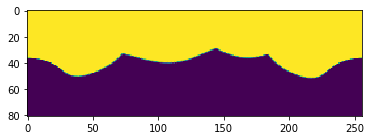

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
im1 = misc.imread("im1.png")
pol1 = polar_trfm(im1, int(2*B), int(np.round(2*B/np.pi)), 2*A)
plt.imshow(pol1)

In [5]:
print(np.degrees(psi), np.degrees(etta), np.degrees(omegga))

19.8994974874 179.095477387 282.211055276


In [46]:
[ipsi, ietta, iomegga] = np.unravel_index(np.argmax(T), T.shape)
print(ipsi, ietta, iomegga)
psi = psi_net[ipsi]
etta = eta_net[ietta - ipsi]
omegga = omega_net[iomegga - ietta ]
print(np.degrees(psi), np.degrees(etta), np.degrees(omegga))

39 5 100


IndexError: index -34 is out of bounds for axis 0 with size 12

In [162]:
np.degrees(psi_net)

array([   0.,   12.,   24.,   36.,   48.,   60.,   72.,   84.,   96.,
        108.,  120.,  132.,  144.,  156.,  168.,  180.,  192.,  204.,
        216.,  228.,  240.,  252.,  264.,  276.,  288.,  300.,  312.,
        324.,  336.,  348.,  360.])

In [143]:
np.degrees(eta_net)

array([   0.,   40.,   80.,  120.,  160.,  200.,  240.,  280.,  320.,  360.])

In [110]:
etta_net =[]
i = 0
for e in eta_net:
    for p in psi_net:
        etta_net.append(p+e)
        i+=1
        
print(i, len(eta_net), len(psi_net))
etta_net = np.array(etta_net)
# enet = etta_net[etta_net < 2*np.pi]
print(np.degrees(etta_net), len(enet))

147 7 21
[   0.   18.   36.   54.   72.   90.  108.  126.  144.  162.  180.  198.
  216.  234.  252.  270.  288.  306.  324.  342.  360.   60.   78.   96.
  114.  132.  150.  168.  186.  204.  222.  240.  258.  276.  294.  312.
  330.  348.  366.  384.  402.  420.  120.  138.  156.  174.  192.  210.
  228.  246.  264.  282.  300.  318.  336.  354.  372.  390.  408.  426.
  444.  462.  480.  180.  198.  216.  234.  252.  270.  288.  306.  324.
  342.  360.  378.  396.  414.  432.  450.  468.  486.  504.  522.  540.
  240.  258.  276.  294.  312.  330.  348.  366.  384.  402.  420.  438.
  456.  474.  492.  510.  528.  546.  564.  582.  600.  300.  318.  336.
  354.  372.  390.  408.  426.  444.  462.  480.  498.  516.  534.  552.
  570.  588.  606.  624.  642.  660.  360.  378.  396.  414.  432.  450.
  468.  486.  504.  522.  540.  558.  576.  594.  612.  630.  648.  666.
  684.  702.  720.] 72


In [92]:
np.degrees(omega_net)

array([   0. ,    1.8,    3.6,    5.4,    7.2,    9. ,   10.8,   12.6,
         14.4,   16.2,   18. ,   19.8,   21.6,   23.4,   25.2,   27. ,
         28.8,   30.6,   32.4,   34.2,   36. ,   37.8,   39.6,   41.4,
         43.2,   45. ,   46.8,   48.6,   50.4,   52.2,   54. ,   55.8,
         57.6,   59.4,   61.2,   63. ,   64.8,   66.6,   68.4,   70.2,
         72. ,   73.8,   75.6,   77.4,   79.2,   81. ,   82.8,   84.6,
         86.4,   88.2,   90. ,   91.8,   93.6,   95.4,   97.2,   99. ,
        100.8,  102.6,  104.4,  106.2,  108. ,  109.8,  111.6,  113.4,
        115.2,  117. ,  118.8,  120.6,  122.4,  124.2,  126. ,  127.8,
        129.6,  131.4,  133.2,  135. ,  136.8,  138.6,  140.4,  142.2,
        144. ,  145.8,  147.6,  149.4,  151.2,  153. ,  154.8,  156.6,
        158.4,  160.2,  162. ,  163.8,  165.6,  167.4,  169.2,  171. ,
        172.8,  174.6,  176.4,  178.2,  180. ,  181.8,  183.6,  185.4,
        187.2,  189. ,  190.8,  192.6,  194.4,  196.2,  198. ,  199.8,
      

## Визуализация

[]

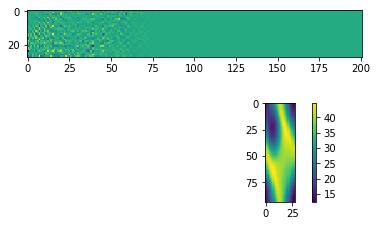

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.imshow(np.real(Tf[1,:,:]))
plt.subplot(2,1,2)
plt.imshow(np.real(abs(T[:,:,10])))
plt.colorbar()
plt.plot()

## Комментарии

In [ ]:
# for it_m1 in tqdm.tqdm(range(len(Im1))):
#     m1 = Im1[it_m1]
#     c1 = sp.special.jn(m1, b * x_net) * x_net
#     for it_h1 in range(len(Ih1)):
#         h1 = Ih1[it_h1]
#         # c2 = c2_coefs[it_m1, it_h1, :]
#         c2 = sp.special.jn(h1, b * x_net) * c1
#         for it_mm in range(len(Imm)):
#             mm = Imm[it_mm]
#             coef = 2*np.pi * np.exp(1j*(h1+mm)*eps)
#             # Fm = FBT(pol1, m1+h1+mm, x_net, u_net, theta_net)
# #             Fm_arr[it_m1 + it_h1 + it_mm] = Fm
#             Fm = Fm_arr[it_m1 + it_h1 + it_mm]
#             Gm = FBT(pol2, mm, x_net, u_net, theta_net)
#             func = Fm*np.conj(Gm)*c2
#             Tf[it_m1, it_h1, it_mm] = np.trapz(sp.real(func), x_net) \
#                                       + 1j*np.trapz(sp.imag(func), x_net)
#             Tf[it_m1, it_h1, it_mm] = Tf[it_m1, it_h1, it_mm] * coef